# Federated mortality prediction

We'll split the train data into two workers and train the model in a federated way using PySyft. 

This was adopted from one of the basic [PySyft tutorials](https://github.com/OpenMined/PySyft/blob/dev/examples/tutorials/Part%2004%20-%20Federated%20Learning%20via%20Trusted%20Aggregator.ipynb).

To keep it really simple, we'll ignore the categorical variables and diag columns for now and just use the apache and lab values.

In [2]:
import torch
import syft as sy
import copy
hook = sy.TorchHook(torch)
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc

## Load, preprocess data

In [2]:
df = pd.read_csv('orpp_all.csv').set_index('patientunitstayid')
# keep apache and lab values only - all numeric
df = df.iloc[:, 4:107]
# scale X
scaler = RobustScaler(quantile_range=(10.0, 90.0))
df = scaler.fit_transform(df.values)

# load y
df_y = pd.read_csv('mort_y.csv')

### Setup training/test data

In [3]:
# do train-test split without scikit to keep the data with its col names - see later
np.random.seed(12)
test_ratio = 0.1
train_ix = np.random.rand(len(df)) < 1 - test_ratio

# define X and y, then split it into train (90%) and test (10%)
y = df_y['hosp_mort'].values
X_train = df[train_ix].astype('float32')
y_train = y[train_ix].astype('float32')
X_test = df[~train_ix].astype('float32')
y_test = y[~train_ix].astype('float32')

# now split training into 2 equal parts randomly - simulating two distinct datasets
hosp1_ix = np.random.rand(X_train.shape[0]) < 0.5

## Create Data Owners

First, we're going to create two data owners (Hospital1 and Hospital2), with the same amount of data. We're also going to initialize a secure machine called "secure_worker". In practice this could be secure hardware (such as Intel's SGX) or simply a trusted intermediary. 

In [23]:
# create a couple workers
hosp1 = sy.VirtualWorker(hook, id="hospital1")
hosp2 = sy.VirtualWorker(hook, id="hospital2")
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

# A Toy Dataset
data = torch.tensor(X_train, requires_grad=False)
target = torch.tensor(y_train, requires_grad=False)

# get pointers to training data on each worker by sending some training data to hospital1 and 2
hosp1_data = data[np.where(hosp1_ix)[0]].send(hosp1)
hosp1_target = target[np.where(hosp1_ix)[0]].send(hosp1)
hosp1_data_n = len(hosp1_data)

hosp2_data = data[np.where(~hosp1_ix)[0]].send(hosp2)
hosp2_target = target[np.where(~hosp1_ix)[0]].send(hosp2)
hosp2_data_n = len(hosp2_data)

## Create DNN model.

Then send it to hospital 1 and 2.


In [6]:
DENSE_SIZE = 1024
BATCH_SIZE = 1024
DROPOUT = 0.5

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(103, DENSE_SIZE)
        self.fc2 = nn.Linear(DENSE_SIZE, int(DENSE_SIZE/2))
        self.fc3 = nn.Linear(int(DENSE_SIZE/2), int(DENSE_SIZE/4))
        self.fc4 = nn.Linear(int(DENSE_SIZE/4), 1)
        self.do = nn.Dropout(p=DROPOUT)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.do(F.relu(self.fc1(x)))
        x = self.do(F.relu(self.fc2(x)))
        x = self.do(F.relu(self.fc3(x)))
        x = self.sigm(self.fc4(x))
        return x
model = Net()

## Train the federated model

As is conventional with Federated Learning via Secure Averaging, each data owner first trains their model for several iterations locally before the models are averaged together.

In [16]:
def get_ix(batch, batch_size, total_size):
    start = batch * batch_size
    if start > total_size:
        raise ValueError('We ran out of data captain!')
    end = start + batch_size
    if end > total_size:
        end = total_size
    return slice(start, end, 1)

In [24]:
# epoch vars for local and global iterations
GLOBAL_EPOCHS = 20
LOCAL_EPOCHS = 5
criterion = torch.nn.BCELoss()

for e in range(GLOBAL_EPOCHS):
    print('------------------------------------\nGLOBAL EPOCH %d' % e)
    # send the current version of the model to the hospitals
    hosp1_model = model.copy().send(hosp1)
    hosp2_model = model.copy().send(hosp2)
    
    # redefine the optimizer
    hosp1_opt = optim.SGD(params=hosp1_model.parameters(),lr=5e-3, momentum=0.9)
    hosp2_opt = optim.SGD(params=hosp2_model.parameters(),lr=5e-3, momentum=0.9)

    for le in range(LOCAL_EPOCHS):
        print('LOCAL EPOCH %d' % le)
        # train hospital1's model
        batch_num = int(np.ceil(hosp1_data_n / BATCH_SIZE))
        for b in range(batch_num):
            ix = get_ix(b, BATCH_SIZE, hosp1_data_n)
            b_data = hosp1_data[ix]
            b_target = hosp1_target[ix]
            hosp1_opt.zero_grad()
            hosp1_pred = hosp1_model(b_data)
            hosp1_loss = criterion(hosp1_pred, b_target)
            hosp1_loss.backward()
            hosp1_opt.step()
        
        # shuffle hospital data and target
        si = torch.randperm(hosp1_data_n).send(hosp1)
        hosp1_data = hosp1_data[si]
        hosp1_target = hosp1_target[si]
        # print progress
        hosp1_loss = hosp1_loss.get().data
        print('Hospital 1 loss:' + str(hosp1_loss))

        # train hospital2's model
        batch_num = int(np.ceil(hosp2_data_n / BATCH_SIZE))
        for b in range(batch_num):
            ix = get_ix(b, BATCH_SIZE, hosp2_data_n)
            b_data = hosp2_data[ix]
            b_target = hosp2_target[ix]
            hosp2_opt.zero_grad()
            hosp2_pred = hosp2_model(b_data)
            hosp2_loss = criterion(hosp2_pred, b_target)
            hosp2_loss.backward()
            hosp2_opt.step()
        
        # shuffle hospital data and target
        si = torch.randperm(hosp2_data_n).send(hosp2)
        hosp2_data = hosp2_data[si]
        hosp2_target = hosp2_target[si]
        # print progress
        hosp2_loss = hosp2_loss.get().data
        print('Hospital 2 loss:' + str(hosp2_loss))
              
    # Now that each data owner has a partially trained model, it's time to average them
    # together in a secure way. We achieve this by instructing Hospital 1 and 2 to send 
    # their model to the secure (trusted) server. 
    hosp1_model.move(secure_worker)
    hosp2_model.move(secure_worker)
    
    # Finally, the last step for this training epoch is to average the two trained models 
    # together and then use this to set the values for our global "model". 
    with torch.no_grad():
        all_params = zip(
            model.parameters(),
            hosp1_model.parameters(), 
            hosp2_model.parameters()
        )
        for p0, p1, p2 in all_params:
            p0.set_(((p1 + p2) / 2).get())
    
    # report on progress
    print("Hospital1:" + str(hosp2_loss) + " Hospital2:" + str(hosp2_loss))    

------------------------------------
GLOBAL EPOCH 0
LOCAL EPOCH 0


/home/danielhomola/.virtualenvs/tf/lib/python3.6/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:308: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])) is deprecated. Please ensure they have the same size.
  response = eval(cmd)(*args, **kwargs)
/home/danielhomola/.virtualenvs/tf/lib/python3.6/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:308: UserWarning: Using a target size (torch.Size([223])) that is different to the input size (torch.Size([223, 1])) is deprecated. Please ensure they have the same size.
  response = eval(cmd)(*args, **kwargs)


Hospital 1 loss:tensor(0.5909)


/home/danielhomola/.virtualenvs/tf/lib/python3.6/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:308: UserWarning: Using a target size (torch.Size([356])) that is different to the input size (torch.Size([356, 1])) is deprecated. Please ensure they have the same size.
  response = eval(cmd)(*args, **kwargs)


Hospital 2 loss:tensor(0.6178)
LOCAL EPOCH 1
Hospital 1 loss:tensor(0.5386)
Hospital 2 loss:tensor(0.5212)
LOCAL EPOCH 2
Hospital 1 loss:tensor(0.5234)
Hospital 2 loss:tensor(0.5366)
LOCAL EPOCH 3
Hospital 1 loss:tensor(0.4647)
Hospital 2 loss:tensor(0.4632)
LOCAL EPOCH 4
Hospital 1 loss:tensor(0.4647)
Hospital 2 loss:tensor(0.4466)
Hospital1:tensor(0.4466) Hospital2:tensor(0.4466)
------------------------------------
GLOBAL EPOCH 1
LOCAL EPOCH 0
Hospital 1 loss:tensor(0.4321)
Hospital 2 loss:tensor(0.4142)
LOCAL EPOCH 1
Hospital 1 loss:tensor(0.3823)
Hospital 2 loss:tensor(0.4416)
LOCAL EPOCH 2
Hospital 1 loss:tensor(0.3797)
Hospital 2 loss:tensor(0.4108)
LOCAL EPOCH 3
Hospital 1 loss:tensor(0.3579)
Hospital 2 loss:tensor(0.3698)
LOCAL EPOCH 4
Hospital 1 loss:tensor(0.3221)
Hospital 2 loss:tensor(0.3464)
Hospital1:tensor(0.3464) Hospital2:tensor(0.3464)
------------------------------------
GLOBAL EPOCH 2
LOCAL EPOCH 0
Hospital 1 loss:tensor(0.3464)
Hospital 2 loss:tensor(0.3428)
LOCAL

Lastly, we want to make sure that our resulting model learned correctly, so we'll evaluate it on a test dataset.  In this toy problem, we'll use the original data, but in practice we'll want to use new data to understand how well the model generalizes to unseen examples.

In [25]:
preds = model(torch.tensor(X_test))
preds = preds.data.numpy()

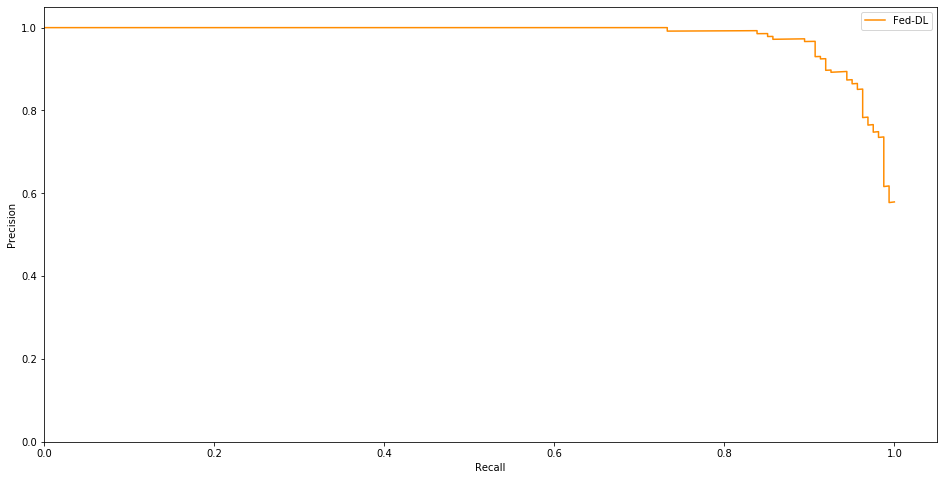

In [26]:
prec, rec, _ = precision_recall_curve(y_test, preds)
plt.rcParams["figure.figsize"] = (16,8)
plt.figure()
plt.plot(rec, prec, color='darkorange', label='Fed-DL')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()